# Delta printer geometry calibration using bed auto-leveling

Copyright (c) 2015 Matti Airas

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.

## Initial setup

In [1]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import matplotlib.pyplot as plt

import numpy as np
from scipy.optimize import leastsq, minimize

In [2]:
%matplotlib inline

Import calibration data. The calibration data should be acquired by first running commands "G28" and then "G29 V3" on the printer. To increase the amount of points, you can set AUTO_BED_LEVELING_GRID_POINTS to some larger value. I used 25.

In [3]:
in_data = """
< 21:10:41: Bed X: 0.000 Y: -70.000 Z: 1.370
< 21:10:42: Bed X: 25.000 Y: -65.000 Z: 1.280
< 21:10:42: Bed X: 20.000 Y: -65.000 Z: 1.390
< 21:10:43: Bed X: 15.000 Y: -65.000 Z: 1.430
< 21:10:43: Bed X: 10.000 Y: -65.000 Z: 1.500
< 21:10:44: Bed X: 5.000 Y: -65.000 Z: 1.530
< 21:10:44: Bed X: 0.000 Y: -65.000 Z: 1.590
< 21:10:45: Bed X: -5.000 Y: -65.000 Z: 1.610
< 21:10:45: Bed X: -10.000 Y: -65.000 Z: 1.640
< 21:10:46: Bed X: -15.000 Y: -65.000 Z: 1.610
< 21:10:46: Bed X: -20.000 Y: -65.000 Z: 1.580
< 21:10:47: Bed X: -25.000 Y: -65.000 Z: 1.520
< 21:10:48: Bed X: -35.000 Y: -60.000 Z: 1.420
< 21:10:48: Bed X: -30.000 Y: -60.000 Z: 1.510
< 21:10:49: Bed X: -25.000 Y: -60.000 Z: 1.590
< 21:10:49: Bed X: -20.000 Y: -60.000 Z: 1.620
< 21:10:50: Bed X: -15.000 Y: -60.000 Z: 1.660
< 21:10:50: Bed X: -10.000 Y: -60.000 Z: 1.680
< 21:10:51: Bed X: -5.000 Y: -60.000 Z: 1.660
< 21:10:51: Bed X: 0.000 Y: -60.000 Z: 1.660
< 21:10:52: Bed X: 5.000 Y: -60.000 Z: 1.660
< 21:10:52: Bed X: 10.000 Y: -60.000 Z: 1.620
< 21:10:53: Bed X: 15.000 Y: -60.000 Z: 1.570
< 21:10:53: Bed X: 20.000 Y: -60.000 Z: 1.510
< 21:10:54: Bed X: 25.000 Y: -60.000 Z: 1.430
< 21:10:54: Bed X: 30.000 Y: -60.000 Z: 1.350
< 21:10:55: Bed X: 35.000 Y: -60.000 Z: 1.260
< 21:10:56: Bed X: 40.000 Y: -55.000 Z: 1.350
< 21:10:56: Bed X: 35.000 Y: -55.000 Z: 1.360
< 21:10:57: Bed X: 30.000 Y: -55.000 Z: 1.450
< 21:10:57: Bed X: 25.000 Y: -55.000 Z: 1.560
< 21:10:58: Bed X: 20.000 Y: -55.000 Z: 1.620
< 21:10:58: Bed X: 15.000 Y: -55.000 Z: 1.670
< 21:10:59: Bed X: 10.000 Y: -55.000 Z: 1.710
< 21:10:59: Bed X: 5.000 Y: -55.000 Z: 1.730
< 21:11:00: Bed X: 0.000 Y: -55.000 Z: 1.740
< 21:11:00: Bed X: -5.000 Y: -55.000 Z: 1.740
< 21:11:01: Bed X: -10.000 Y: -55.000 Z: 1.740
< 21:11:01: Bed X: -15.000 Y: -55.000 Z: 1.730
< 21:11:02: Bed X: -20.000 Y: -55.000 Z: 1.700
< 21:11:02: Bed X: -25.000 Y: -55.000 Z: 1.650
< 21:11:03: Bed X: -30.000 Y: -55.000 Z: 1.580
< 21:11:04: Bed X: -35.000 Y: -55.000 Z: 1.510
< 21:11:04: Bed X: -40.000 Y: -55.000 Z: 1.430
< 21:11:05: Bed X: -45.000 Y: -50.000 Z: 1.430
< 21:11:05: Bed X: -40.000 Y: -50.000 Z: 1.480
< 21:11:06: Bed X: -35.000 Y: -50.000 Z: 1.540
< 21:11:06: Bed X: -30.000 Y: -50.000 Z: 1.620
< 21:11:07: Bed X: -25.000 Y: -50.000 Z: 1.690
< 21:11:07: Bed X: -20.000 Y: -50.000 Z: 1.740
< 21:11:08: Bed X: -15.000 Y: -50.000 Z: 1.780
< 21:11:08: Bed X: -10.000 Y: -50.000 Z: 1.790
< 21:11:09: Bed X: -5.000 Y: -50.000 Z: 1.830
< 21:11:09: Bed X: 0.000 Y: -50.000 Z: 1.840
< 21:11:10: Bed X: 5.000 Y: -50.000 Z: 1.840
< 21:11:10: Bed X: 10.000 Y: -50.000 Z: 1.820
< 21:11:11: Bed X: 15.000 Y: -50.000 Z: 1.780
< 21:11:12: Bed X: 20.000 Y: -50.000 Z: 1.720
< 21:11:12: Bed X: 25.000 Y: -50.000 Z: 1.680
< 21:11:13: Bed X: 30.000 Y: -50.000 Z: 1.590
< 21:11:13: Bed X: 35.000 Y: -50.000 Z: 1.500
< 21:11:14: Bed X: 40.000 Y: -50.000 Z: 1.440
< 21:11:14: Bed X: 45.000 Y: -50.000 Z: 1.370
< 21:11:15: Bed X: 50.000 Y: -45.000 Z: 1.490
< 21:11:15: Bed X: 45.000 Y: -45.000 Z: 1.500
< 21:11:16: Bed X: 40.000 Y: -45.000 Z: 1.550
< 21:11:16: Bed X: 35.000 Y: -45.000 Z: 1.630
< 21:11:17: Bed X: 30.000 Y: -45.000 Z: 1.700
< 21:11:18: Bed X: 25.000 Y: -45.000 Z: 1.790
< 21:11:18: Bed X: 20.000 Y: -45.000 Z: 1.840
< 21:11:19: Bed X: 15.000 Y: -45.000 Z: 1.900
< 21:11:19: Bed X: 10.000 Y: -45.000 Z: 1.910
< 21:11:20: Bed X: 5.000 Y: -45.000 Z: 1.930
< 21:11:20: Bed X: 0.000 Y: -45.000 Z: 1.910
< 21:11:21: Bed X: -5.000 Y: -45.000 Z: 1.920
< 21:11:21: Bed X: -10.000 Y: -45.000 Z: 1.880
< 21:11:22: Bed X: -15.000 Y: -45.000 Z: 1.870
< 21:11:22: Bed X: -20.000 Y: -45.000 Z: 1.810
< 21:11:23: Bed X: -25.000 Y: -45.000 Z: 1.750
< 21:11:23: Bed X: -30.000 Y: -45.000 Z: 1.690
< 21:11:24: Bed X: -35.000 Y: -45.000 Z: 1.620
< 21:11:24: Bed X: -40.000 Y: -45.000 Z: 1.520
< 21:11:25: Bed X: -45.000 Y: -45.000 Z: 1.460
< 21:11:26: Bed X: -50.000 Y: -45.000 Z: 1.410
< 21:11:26: Bed X: -55.000 Y: -40.000 Z: 1.360
< 21:11:27: Bed X: -50.000 Y: -40.000 Z: 1.440
< 21:11:27: Bed X: -45.000 Y: -40.000 Z: 1.530
< 21:11:28: Bed X: -40.000 Y: -40.000 Z: 1.580
< 21:11:28: Bed X: -35.000 Y: -40.000 Z: 1.670
< 21:11:29: Bed X: -30.000 Y: -40.000 Z: 1.750
< 21:11:29: Bed X: -25.000 Y: -40.000 Z: 1.820
< 21:11:30: Bed X: -20.000 Y: -40.000 Z: 1.880
< 21:11:30: Bed X: -15.000 Y: -40.000 Z: 1.920
< 21:11:31: Bed X: -10.000 Y: -40.000 Z: 1.950
< 21:11:31: Bed X: -5.000 Y: -40.000 Z: 2.010
< 21:11:32: Bed X: 0.000 Y: -40.000 Z: 2.010
< 21:11:32: Bed X: 5.000 Y: -40.000 Z: 2.030
< 21:11:33: Bed X: 10.000 Y: -40.000 Z: 2.010
< 21:11:34: Bed X: 15.000 Y: -40.000 Z: 2.010
< 21:11:34: Bed X: 20.000 Y: -40.000 Z: 1.960
< 21:11:35: Bed X: 25.000 Y: -40.000 Z: 1.920
< 21:11:35: Bed X: 30.000 Y: -40.000 Z: 1.820
< 21:11:36: Bed X: 35.000 Y: -40.000 Z: 1.770
< 21:11:36: Bed X: 40.000 Y: -40.000 Z: 1.670
< 21:11:37: Bed X: 45.000 Y: -40.000 Z: 1.610
< 21:11:37: Bed X: 50.000 Y: -40.000 Z: 1.640
< 21:11:38: Bed X: 50.000 Y: -35.000 Z: 1.740
< 21:11:38: Bed X: 45.000 Y: -35.000 Z: 1.750
< 21:11:39: Bed X: 40.000 Y: -35.000 Z: 1.810
< 21:11:39: Bed X: 35.000 Y: -35.000 Z: 1.870
< 21:11:40: Bed X: 30.000 Y: -35.000 Z: 1.940
< 21:11:41: Bed X: 25.000 Y: -35.000 Z: 2.010
< 21:11:41: Bed X: 20.000 Y: -35.000 Z: 2.060
< 21:11:42: Bed X: 15.000 Y: -35.000 Z: 2.100
< 21:11:42: Bed X: 10.000 Y: -35.000 Z: 2.110
< 21:11:43: Bed X: 5.000 Y: -35.000 Z: 2.100
< 21:11:43: Bed X: 0.000 Y: -35.000 Z: 2.090
< 21:11:44: Bed X: -5.000 Y: -35.000 Z: 2.090
< 21:11:44: Bed X: -10.000 Y: -35.000 Z: 2.030
< 21:11:45: Bed X: -15.000 Y: -35.000 Z: 2.020
< 21:11:45: Bed X: -20.000 Y: -35.000 Z: 1.950
< 21:11:46: Bed X: -25.000 Y: -35.000 Z: 1.910
< 21:11:46: Bed X: -30.000 Y: -35.000 Z: 1.830
< 21:11:47: Bed X: -35.000 Y: -35.000 Z: 1.760
< 21:11:47: Bed X: -40.000 Y: -35.000 Z: 1.660
< 21:11:48: Bed X: -45.000 Y: -35.000 Z: 1.570
< 21:11:49: Bed X: -50.000 Y: -35.000 Z: 1.510
< 21:11:49: Bed X: -55.000 Y: -35.000 Z: 1.450
< 21:11:50: Bed X: -60.000 Y: -35.000 Z: 1.350
< 21:11:50: Bed X: -60.000 Y: -30.000 Z: 1.380
< 21:11:51: Bed X: -55.000 Y: -30.000 Z: 1.500
< 21:11:51: Bed X: -50.000 Y: -30.000 Z: 1.540
< 21:11:52: Bed X: -45.000 Y: -30.000 Z: 1.640
< 21:11:52: Bed X: -40.000 Y: -30.000 Z: 1.720
< 21:11:53: Bed X: -35.000 Y: -30.000 Z: 1.830
< 21:11:53: Bed X: -30.000 Y: -30.000 Z: 1.920
< 21:11:54: Bed X: -25.000 Y: -30.000 Z: 2.000
< 21:11:55: Bed X: -20.000 Y: -30.000 Z: 2.050
< 21:11:55: Bed X: -15.000 Y: -30.000 Z: 2.110
< 21:11:56: Bed X: -10.000 Y: -30.000 Z: 2.150
< 21:11:56: Bed X: -5.000 Y: -30.000 Z: 2.210
< 21:11:57: Bed X: 0.000 Y: -30.000 Z: 2.200
< 21:11:57: Bed X: 5.000 Y: -30.000 Z: 2.220
< 21:11:58: Bed X: 10.000 Y: -30.000 Z: 2.230
< 21:11:58: Bed X: 15.000 Y: -30.000 Z: 2.230
< 21:11:59: Bed X: 20.000 Y: -30.000 Z: 2.200
< 21:11:59: Bed X: 25.000 Y: -30.000 Z: 2.120
< 21:12:00: Bed X: 30.000 Y: -30.000 Z: 2.080
< 21:12:00: Bed X: 35.000 Y: -30.000 Z: 1.990
< 21:12:01: Bed X: 40.000 Y: -30.000 Z: 1.930
< 21:12:01: Bed X: 45.000 Y: -30.000 Z: 1.890
< 21:12:02: Bed X: 50.000 Y: -30.000 Z: 1.870
< 21:12:03: Bed X: 50.000 Y: -25.000 Z: 2.000
< 21:12:03: Bed X: 45.000 Y: -25.000 Z: 1.990
< 21:12:04: Bed X: 40.000 Y: -25.000 Z: 2.040
< 21:12:04: Bed X: 35.000 Y: -25.000 Z: 2.100
< 21:12:05: Bed X: 30.000 Y: -25.000 Z: 2.170
< 21:12:05: Bed X: 25.000 Y: -25.000 Z: 2.240
< 21:12:06: Bed X: 20.000 Y: -25.000 Z: 2.280
< 21:12:06: Bed X: 15.000 Y: -25.000 Z: 2.280
< 21:12:07: Bed X: 10.000 Y: -25.000 Z: 2.310
< 21:12:07: Bed X: 5.000 Y: -25.000 Z: 2.300
< 21:12:08: Bed X: 0.000 Y: -25.000 Z: 2.280
< 21:12:08: Bed X: -5.000 Y: -25.000 Z: 2.260
< 21:12:09: Bed X: -10.000 Y: -25.000 Z: 2.210
< 21:12:09: Bed X: -15.000 Y: -25.000 Z: 2.170
< 21:12:10: Bed X: -20.000 Y: -25.000 Z: 2.120
< 21:12:11: Bed X: -25.000 Y: -25.000 Z: 2.060
< 21:12:11: Bed X: -30.000 Y: -25.000 Z: 1.990
< 21:12:12: Bed X: -35.000 Y: -25.000 Z: 1.900
< 21:12:12: Bed X: -40.000 Y: -25.000 Z: 1.810
< 21:12:13: Bed X: -45.000 Y: -25.000 Z: 1.720
< 21:12:13: Bed X: -50.000 Y: -25.000 Z: 1.640
< 21:12:14: Bed X: -55.000 Y: -25.000 Z: 1.560
< 21:12:14: Bed X: -60.000 Y: -25.000 Z: 1.450
< 21:12:15: Bed X: -65.000 Y: -25.000 Z: 1.350
< 21:12:16: Bed X: -65.000 Y: -20.000 Z: 1.420
< 21:12:16: Bed X: -60.000 Y: -20.000 Z: 1.520
< 21:12:17: Bed X: -55.000 Y: -20.000 Z: 1.630
< 21:12:17: Bed X: -50.000 Y: -20.000 Z: 1.710
< 21:12:18: Bed X: -45.000 Y: -20.000 Z: 1.770
< 21:12:18: Bed X: -40.000 Y: -20.000 Z: 1.880
< 21:12:19: Bed X: -35.000 Y: -20.000 Z: 2.000
< 21:12:19: Bed X: -30.000 Y: -20.000 Z: 2.070
< 21:12:20: Bed X: -25.000 Y: -20.000 Z: 2.130
< 21:12:20: Bed X: -20.000 Y: -20.000 Z: 2.200
< 21:12:21: Bed X: -15.000 Y: -20.000 Z: 2.260
< 21:12:21: Bed X: -10.000 Y: -20.000 Z: 2.300
< 21:12:22: Bed X: -5.000 Y: -20.000 Z: 2.350
< 21:12:22: Bed X: 0.000 Y: -20.000 Z: 2.380
< 21:12:23: Bed X: 5.000 Y: -20.000 Z: 2.400
< 21:12:24: Bed X: 10.000 Y: -20.000 Z: 2.390
< 21:12:24: Bed X: 15.000 Y: -20.000 Z: 2.400
< 21:12:25: Bed X: 20.000 Y: -20.000 Z: 2.370
< 21:12:25: Bed X: 25.000 Y: -20.000 Z: 2.330
< 21:12:26: Bed X: 30.000 Y: -20.000 Z: 2.280
< 21:12:26: Bed X: 35.000 Y: -20.000 Z: 2.220
< 21:12:27: Bed X: 40.000 Y: -20.000 Z: 2.170
< 21:12:27: Bed X: 45.000 Y: -20.000 Z: 2.140
< 21:12:28: Bed X: 50.000 Y: -20.000 Z: 2.130
< 21:12:28: Bed X: 50.000 Y: -15.000 Z: 2.220
< 21:12:29: Bed X: 45.000 Y: -15.000 Z: 2.270
< 21:12:30: Bed X: 40.000 Y: -15.000 Z: 2.250
< 21:12:30: Bed X: 35.000 Y: -15.000 Z: 2.310
< 21:12:31: Bed X: 30.000 Y: -15.000 Z: 2.380
< 21:12:31: Bed X: 25.000 Y: -15.000 Z: 2.430
< 21:12:32: Bed X: 20.000 Y: -15.000 Z: 2.470
< 21:12:32: Bed X: 15.000 Y: -15.000 Z: 2.500
< 21:12:33: Bed X: 10.000 Y: -15.000 Z: 2.490
< 21:12:33: Bed X: 5.000 Y: -15.000 Z: 2.480
< 21:12:34: Bed X: 0.000 Y: -15.000 Z: 2.440
< 21:12:34: Bed X: -5.000 Y: -15.000 Z: 2.380
< 21:12:35: Bed X: -10.000 Y: -15.000 Z: 2.380
< 21:12:35: Bed X: -15.000 Y: -15.000 Z: 2.330
< 21:12:36: Bed X: -20.000 Y: -15.000 Z: 2.290
< 21:12:36: Bed X: -25.000 Y: -15.000 Z: 2.220
< 21:12:37: Bed X: -30.000 Y: -15.000 Z: 2.150
< 21:12:38: Bed X: -35.000 Y: -15.000 Z: 2.060
< 21:12:38: Bed X: -40.000 Y: -15.000 Z: 1.980
< 21:12:39: Bed X: -45.000 Y: -15.000 Z: 1.880
< 21:12:39: Bed X: -50.000 Y: -15.000 Z: 1.790
< 21:12:40: Bed X: -55.000 Y: -15.000 Z: 1.730
< 21:12:40: Bed X: -60.000 Y: -15.000 Z: 1.630
< 21:12:41: Bed X: -65.000 Y: -15.000 Z: 1.520
< 21:12:41: Bed X: -65.000 Y: -10.000 Z: 1.570
< 21:12:42: Bed X: -60.000 Y: -10.000 Z: 1.670
< 21:12:43: Bed X: -55.000 Y: -10.000 Z: 1.770
< 21:12:43: Bed X: -50.000 Y: -10.000 Z: 1.870
< 21:12:44: Bed X: -45.000 Y: -10.000 Z: 1.940
< 21:12:44: Bed X: -40.000 Y: -10.000 Z: 2.040
< 21:12:45: Bed X: -35.000 Y: -10.000 Z: 2.130
< 21:12:45: Bed X: -30.000 Y: -10.000 Z: 2.220
< 21:12:46: Bed X: -25.000 Y: -10.000 Z: 2.300
< 21:12:46: Bed X: -20.000 Y: -10.000 Z: 2.370
< 21:12:47: Bed X: -15.000 Y: -10.000 Z: 2.410
< 21:12:47: Bed X: -10.000 Y: -10.000 Z: 2.470
< 21:12:48: Bed X: -5.000 Y: -10.000 Z: 2.530
< 21:12:48: Bed X: 0.000 Y: -10.000 Z: 2.540
< 21:12:49: Bed X: 5.000 Y: -10.000 Z: 2.560
< 21:12:49: Bed X: 10.000 Y: -10.000 Z: 2.590
< 21:12:50: Bed X: 15.000 Y: -10.000 Z: 2.600
< 21:12:50: Bed X: 20.000 Y: -10.000 Z: 2.570
< 21:12:51: Bed X: 25.000 Y: -10.000 Z: 2.530
< 21:12:52: Bed X: 30.000 Y: -10.000 Z: 2.480
< 21:12:52: Bed X: 35.000 Y: -10.000 Z: 2.410
< 21:12:53: Bed X: 40.000 Y: -10.000 Z: 2.350
< 21:12:53: Bed X: 45.000 Y: -10.000 Z: 2.340
< 21:12:54: Bed X: 50.000 Y: -10.000 Z: 2.310
< 21:12:54: Bed X: 50.000 Y: -5.000 Z: 2.430
< 21:12:55: Bed X: 45.000 Y: -5.000 Z: 2.410
< 21:12:55: Bed X: 40.000 Y: -5.000 Z: 2.450
< 21:12:56: Bed X: 35.000 Y: -5.000 Z: 2.490
< 21:12:56: Bed X: 30.000 Y: -5.000 Z: 2.560
< 21:12:57: Bed X: 25.000 Y: -5.000 Z: 2.600
< 21:12:57: Bed X: 20.000 Y: -5.000 Z: 2.650
< 21:12:58: Bed X: 15.000 Y: -5.000 Z: 2.660
< 21:12:59: Bed X: 10.000 Y: -5.000 Z: 2.670
< 21:12:59: Bed X: 5.000 Y: -5.000 Z: 2.650
< 21:13:00: Bed X: 0.000 Y: -5.000 Z: 2.630
< 21:13:00: Bed X: -5.000 Y: -5.000 Z: 2.590
< 21:13:01: Bed X: -10.000 Y: -5.000 Z: 2.550
< 21:13:01: Bed X: -15.000 Y: -5.000 Z: 2.490
< 21:13:02: Bed X: -20.000 Y: -5.000 Z: 2.440
< 21:13:02: Bed X: -25.000 Y: -5.000 Z: 2.370
< 21:13:03: Bed X: -30.000 Y: -5.000 Z: 2.300
< 21:13:03: Bed X: -35.000 Y: -5.000 Z: 2.210
< 21:13:04: Bed X: -40.000 Y: -5.000 Z: 2.110
< 21:13:04: Bed X: -45.000 Y: -5.000 Z: 2.030
< 21:13:05: Bed X: -50.000 Y: -5.000 Z: 1.960
< 21:13:06: Bed X: -55.000 Y: -5.000 Z: 1.870
< 21:13:06: Bed X: -60.000 Y: -5.000 Z: 1.760
< 21:13:07: Bed X: -65.000 Y: -5.000 Z: 1.650
< 21:13:07: Bed X: -70.000 Y: 0.000 Z: 1.610
< 21:13:08: Bed X: -65.000 Y: 0.000 Z: 1.730
< 21:13:08: Bed X: -60.000 Y: 0.000 Z: 1.820
< 21:13:09: Bed X: -55.000 Y: 0.000 Z: 1.920
< 21:13:09: Bed X: -50.000 Y: 0.000 Z: 2.000
< 21:13:10: Bed X: -45.000 Y: 0.000 Z: 2.090
< 21:13:11: Bed X: -40.000 Y: 0.000 Z: 2.180
< 21:13:11: Bed X: -35.000 Y: 0.000 Z: 2.280
< 21:13:12: Bed X: -30.000 Y: 0.000 Z: 2.360
< 21:13:12: Bed X: -25.000 Y: 0.000 Z: 2.460
< 21:13:13: Bed X: -20.000 Y: 0.000 Z: 2.530
< 21:13:13: Bed X: -15.000 Y: 0.000 Z: 2.570
< 21:13:14: Bed X: -10.000 Y: 0.000 Z: 2.650
< 21:13:14: Bed X: -5.000 Y: 0.000 Z: 2.670
< 21:13:15: Bed X: 0.000 Y: 0.000 Z: 2.710
< 21:13:15: Bed X: 5.000 Y: 0.000 Z: 2.740
< 21:13:16: Bed X: 10.000 Y: 0.000 Z: 2.750
< 21:13:16: Bed X: 15.000 Y: 0.000 Z: 2.750
< 21:13:17: Bed X: 20.000 Y: 0.000 Z: 2.750
< 21:13:17: Bed X: 25.000 Y: 0.000 Z: 2.700
< 21:13:18: Bed X: 30.000 Y: 0.000 Z: 2.660
< 21:13:18: Bed X: 35.000 Y: 0.000 Z: 2.590
< 21:13:19: Bed X: 40.000 Y: 0.000 Z: 2.540
< 21:13:20: Bed X: 45.000 Y: 0.000 Z: 2.540
< 21:13:20: Bed X: 50.000 Y: 0.000 Z: 2.530
< 21:13:21: Bed X: 50.000 Y: 5.000 Z: 2.610
< 21:13:21: Bed X: 45.000 Y: 5.000 Z: 2.620
< 21:13:22: Bed X: 40.000 Y: 5.000 Z: 2.640
< 21:13:22: Bed X: 35.000 Y: 5.000 Z: 2.690
< 21:13:23: Bed X: 30.000 Y: 5.000 Z: 2.730
< 21:13:23: Bed X: 25.000 Y: 5.000 Z: 2.790
< 21:13:24: Bed X: 20.000 Y: 5.000 Z: 2.810
< 21:13:24: Bed X: 15.000 Y: 5.000 Z: 2.820
< 21:13:25: Bed X: 10.000 Y: 5.000 Z: 2.830
< 21:13:25: Bed X: 5.000 Y: 5.000 Z: 2.810
< 21:13:26: Bed X: 0.000 Y: 5.000 Z: 2.780
< 21:13:27: Bed X: -5.000 Y: 5.000 Z: 2.750
< 21:13:27: Bed X: -10.000 Y: 5.000 Z: 2.700
< 21:13:28: Bed X: -15.000 Y: 5.000 Z: 2.660
< 21:13:28: Bed X: -20.000 Y: 5.000 Z: 2.600
< 21:13:29: Bed X: -25.000 Y: 5.000 Z: 2.520
< 21:13:29: Bed X: -30.000 Y: 5.000 Z: 2.450
< 21:13:30: Bed X: -35.000 Y: 5.000 Z: 2.360
< 21:13:30: Bed X: -40.000 Y: 5.000 Z: 2.260
< 21:13:31: Bed X: -45.000 Y: 5.000 Z: 2.180
< 21:13:31: Bed X: -50.000 Y: 5.000 Z: 2.090
< 21:13:32: Bed X: -55.000 Y: 5.000 Z: 2.000
< 21:13:33: Bed X: -60.000 Y: 5.000 Z: 1.890
< 21:13:33: Bed X: -65.000 Y: 5.000 Z: 1.800
< 21:13:34: Bed X: -65.000 Y: 10.000 Z: 1.840
< 21:13:34: Bed X: -60.000 Y: 10.000 Z: 1.940
< 21:13:35: Bed X: -55.000 Y: 10.000 Z: 2.050
< 21:13:35: Bed X: -50.000 Y: 10.000 Z: 2.150
< 21:13:36: Bed X: -45.000 Y: 10.000 Z: 2.230
< 21:13:36: Bed X: -40.000 Y: 10.000 Z: 2.310
< 21:13:37: Bed X: -35.000 Y: 10.000 Z: 2.410
< 21:13:37: Bed X: -30.000 Y: 10.000 Z: 2.510
< 21:13:38: Bed X: -25.000 Y: 10.000 Z: 2.600
< 21:13:38: Bed X: -20.000 Y: 10.000 Z: 2.660
< 21:13:39: Bed X: -15.000 Y: 10.000 Z: 2.720
< 21:13:40: Bed X: -10.000 Y: 10.000 Z: 2.780
< 21:13:40: Bed X: -5.000 Y: 10.000 Z: 2.840
< 21:13:41: Bed X: 0.000 Y: 10.000 Z: 2.860
< 21:13:41: Bed X: 5.000 Y: 10.000 Z: 2.910
< 21:13:42: Bed X: 10.000 Y: 10.000 Z: 2.920
< 21:13:42: Bed X: 15.000 Y: 10.000 Z: 2.920
< 21:13:43: Bed X: 20.000 Y: 10.000 Z: 2.900
< 21:13:43: Bed X: 25.000 Y: 10.000 Z: 2.870
< 21:13:44: Bed X: 30.000 Y: 10.000 Z: 2.830
< 21:13:44: Bed X: 35.000 Y: 10.000 Z: 2.790
< 21:13:45: Bed X: 40.000 Y: 10.000 Z: 2.750
< 21:13:45: Bed X: 45.000 Y: 10.000 Z: 2.740
< 21:13:46: Bed X: 50.000 Y: 10.000 Z: 2.750
< 21:13:47: Bed X: 50.000 Y: 15.000 Z: 2.860
< 21:13:47: Bed X: 45.000 Y: 15.000 Z: 2.840
< 21:13:48: Bed X: 40.000 Y: 15.000 Z: 2.830
< 21:13:48: Bed X: 35.000 Y: 15.000 Z: 2.860
< 21:13:49: Bed X: 30.000 Y: 15.000 Z: 2.880
< 21:13:49: Bed X: 25.000 Y: 15.000 Z: 2.920
< 21:13:50: Bed X: 20.000 Y: 15.000 Z: 2.950
< 21:13:50: Bed X: 15.000 Y: 15.000 Z: 2.970
< 21:13:51: Bed X: 10.000 Y: 15.000 Z: 2.970
< 21:13:51: Bed X: 5.000 Y: 15.000 Z: 2.970
< 21:13:52: Bed X: 0.000 Y: 15.000 Z: 2.930
< 21:13:52: Bed X: -5.000 Y: 15.000 Z: 2.880
< 21:13:53: Bed X: -10.000 Y: 15.000 Z: 2.840
< 21:13:53: Bed X: -15.000 Y: 15.000 Z: 2.790
< 21:13:54: Bed X: -20.000 Y: 15.000 Z: 2.740
< 21:13:55: Bed X: -25.000 Y: 15.000 Z: 2.650
< 21:13:55: Bed X: -30.000 Y: 15.000 Z: 2.570
< 21:13:56: Bed X: -35.000 Y: 15.000 Z: 2.490
< 21:13:56: Bed X: -40.000 Y: 15.000 Z: 2.380
< 21:13:57: Bed X: -45.000 Y: 15.000 Z: 2.310
< 21:13:57: Bed X: -50.000 Y: 15.000 Z: 2.220
< 21:13:58: Bed X: -55.000 Y: 15.000 Z: 2.110
< 21:13:58: Bed X: -60.000 Y: 15.000 Z: 2.000
< 21:13:59: Bed X: -65.000 Y: 15.000 Z: 1.910
< 21:13:59: Bed X: -65.000 Y: 20.000 Z: 1.920
< 21:14:00: Bed X: -60.000 Y: 20.000 Z: 2.040
< 21:14:01: Bed X: -55.000 Y: 20.000 Z: 2.160
< 21:14:01: Bed X: -50.000 Y: 20.000 Z: 2.280
< 21:14:02: Bed X: -45.000 Y: 20.000 Z: 2.370
< 21:14:02: Bed X: -40.000 Y: 20.000 Z: 2.450
< 21:14:03: Bed X: -35.000 Y: 20.000 Z: 2.530
< 21:14:03: Bed X: -30.000 Y: 20.000 Z: 2.630
< 21:14:04: Bed X: -25.000 Y: 20.000 Z: 2.720
< 21:14:04: Bed X: -20.000 Y: 20.000 Z: 2.780
< 21:14:05: Bed X: -15.000 Y: 20.000 Z: 2.860
< 21:14:05: Bed X: -10.000 Y: 20.000 Z: 2.920
< 21:14:06: Bed X: -5.000 Y: 20.000 Z: 2.970
< 21:14:06: Bed X: 0.000 Y: 20.000 Z: 3.010
< 21:14:07: Bed X: 5.000 Y: 20.000 Z: 3.050
< 21:14:07: Bed X: 10.000 Y: 20.000 Z: 3.050
< 21:14:08: Bed X: 15.000 Y: 20.000 Z: 3.070
< 21:14:09: Bed X: 20.000 Y: 20.000 Z: 3.050
< 21:14:09: Bed X: 25.000 Y: 20.000 Z: 3.020
< 21:14:10: Bed X: 30.000 Y: 20.000 Z: 2.980
< 21:14:10: Bed X: 35.000 Y: 20.000 Z: 2.960
< 21:14:11: Bed X: 40.000 Y: 20.000 Z: 2.920
< 21:14:11: Bed X: 45.000 Y: 20.000 Z: 2.930
< 21:14:12: Bed X: 50.000 Y: 20.000 Z: 2.950
< 21:14:12: Bed X: 50.000 Y: 25.000 Z: 3.080
< 21:14:13: Bed X: 45.000 Y: 25.000 Z: 3.010
< 21:14:13: Bed X: 40.000 Y: 25.000 Z: 3.010
< 21:14:14: Bed X: 35.000 Y: 25.000 Z: 3.020
< 21:14:15: Bed X: 30.000 Y: 25.000 Z: 3.040
< 21:14:15: Bed X: 25.000 Y: 25.000 Z: 3.060
< 21:14:16: Bed X: 20.000 Y: 25.000 Z: 3.090
< 21:14:16: Bed X: 15.000 Y: 25.000 Z: 3.100
< 21:14:17: Bed X: 10.000 Y: 25.000 Z: 3.100
< 21:14:17: Bed X: 5.000 Y: 25.000 Z: 3.080
< 21:14:18: Bed X: 0.000 Y: 25.000 Z: 3.050
< 21:14:18: Bed X: -5.000 Y: 25.000 Z: 3.010
< 21:14:19: Bed X: -10.000 Y: 25.000 Z: 3.030
< 21:14:19: Bed X: -15.000 Y: 25.000 Z: 2.900
< 21:14:20: Bed X: -20.000 Y: 25.000 Z: 2.840
< 21:14:20: Bed X: -25.000 Y: 25.000 Z: 2.780
< 21:14:21: Bed X: -30.000 Y: 25.000 Z: 2.680
< 21:14:22: Bed X: -35.000 Y: 25.000 Z: 2.580
< 21:14:22: Bed X: -40.000 Y: 25.000 Z: 2.500
< 21:14:23: Bed X: -45.000 Y: 25.000 Z: 2.410
< 21:14:23: Bed X: -50.000 Y: 25.000 Z: 2.310
< 21:14:24: Bed X: -55.000 Y: 25.000 Z: 2.230
< 21:14:24: Bed X: -60.000 Y: 25.000 Z: 2.120
< 21:14:25: Bed X: -65.000 Y: 25.000 Z: 2.010
< 21:14:25: Bed X: -60.000 Y: 30.000 Z: 2.150
< 21:14:26: Bed X: -55.000 Y: 30.000 Z: 2.260
< 21:14:27: Bed X: -50.000 Y: 30.000 Z: 2.360
< 21:14:27: Bed X: -45.000 Y: 30.000 Z: 2.460
< 21:14:28: Bed X: -40.000 Y: 30.000 Z: 2.550
< 21:14:28: Bed X: -35.000 Y: 30.000 Z: 2.640
< 21:14:29: Bed X: -30.000 Y: 30.000 Z: 2.720
< 21:14:29: Bed X: -25.000 Y: 30.000 Z: 2.810
< 21:14:30: Bed X: -20.000 Y: 30.000 Z: 2.890
< 21:14:30: Bed X: -15.000 Y: 30.000 Z: 2.960
< 21:14:31: Bed X: -10.000 Y: 30.000 Z: 3.030
< 21:14:31: Bed X: -5.000 Y: 30.000 Z: 3.070
< 21:14:32: Bed X: 0.000 Y: 30.000 Z: 3.110
< 21:14:32: Bed X: 5.000 Y: 30.000 Z: 3.150
< 21:14:33: Bed X: 10.000 Y: 30.000 Z: 3.150
< 21:14:33: Bed X: 15.000 Y: 30.000 Z: 3.160
< 21:14:34: Bed X: 20.000 Y: 30.000 Z: 3.150
< 21:14:34: Bed X: 25.000 Y: 30.000 Z: 3.130
< 21:14:35: Bed X: 30.000 Y: 30.000 Z: 3.110
< 21:14:36: Bed X: 35.000 Y: 30.000 Z: 3.100
< 21:14:36: Bed X: 40.000 Y: 30.000 Z: 3.090
< 21:14:37: Bed X: 45.000 Y: 30.000 Z: 3.120
< 21:14:37: Bed X: 50.000 Y: 30.000 Z: 3.140
< 21:14:38: Bed X: 50.000 Y: 35.000 Z: 3.210
< 21:14:38: Bed X: 45.000 Y: 35.000 Z: 3.190
< 21:14:39: Bed X: 40.000 Y: 35.000 Z: 3.160
< 21:14:39: Bed X: 35.000 Y: 35.000 Z: 3.140
< 21:14:40: Bed X: 30.000 Y: 35.000 Z: 3.160
< 21:14:40: Bed X: 25.000 Y: 35.000 Z: 3.170
< 21:14:41: Bed X: 20.000 Y: 35.000 Z: 3.180
< 21:14:41: Bed X: 15.000 Y: 35.000 Z: 3.190
< 21:14:42: Bed X: 10.000 Y: 35.000 Z: 3.190
< 21:14:43: Bed X: 5.000 Y: 35.000 Z: 3.170
< 21:14:43: Bed X: 0.000 Y: 35.000 Z: 3.140
< 21:14:44: Bed X: -5.000 Y: 35.000 Z: 3.100
< 21:14:44: Bed X: -10.000 Y: 35.000 Z: 3.060
< 21:14:45: Bed X: -15.000 Y: 35.000 Z: 3.010
< 21:14:45: Bed X: -20.000 Y: 35.000 Z: 2.930
< 21:14:46: Bed X: -25.000 Y: 35.000 Z: 2.850
< 21:14:46: Bed X: -30.000 Y: 35.000 Z: 2.770
< 21:14:47: Bed X: -35.000 Y: 35.000 Z: 2.680
< 21:14:47: Bed X: -40.000 Y: 35.000 Z: 2.600
< 21:14:48: Bed X: -45.000 Y: 35.000 Z: 2.520
< 21:14:49: Bed X: -50.000 Y: 35.000 Z: 2.410
< 21:14:49: Bed X: -55.000 Y: 35.000 Z: 2.310
< 21:14:50: Bed X: -60.000 Y: 35.000 Z: 2.200
< 21:14:50: Bed X: -55.000 Y: 40.000 Z: 2.330
< 21:14:51: Bed X: -50.000 Y: 40.000 Z: 2.450
< 21:14:51: Bed X: -45.000 Y: 40.000 Z: 2.530
< 21:14:52: Bed X: -40.000 Y: 40.000 Z: 2.650
< 21:14:52: Bed X: -35.000 Y: 40.000 Z: 2.720
< 21:14:53: Bed X: -30.000 Y: 40.000 Z: 2.810
< 21:14:53: Bed X: -25.000 Y: 40.000 Z: 2.900
< 21:14:54: Bed X: -20.000 Y: 40.000 Z: 2.980
< 21:14:54: Bed X: -15.000 Y: 40.000 Z: 3.040
< 21:14:55: Bed X: -10.000 Y: 40.000 Z: 3.100
< 21:14:56: Bed X: -5.000 Y: 40.000 Z: 3.150
< 21:14:56: Bed X: 0.000 Y: 40.000 Z: 3.180
< 21:14:57: Bed X: 5.000 Y: 40.000 Z: 3.200
< 21:14:57: Bed X: 10.000 Y: 40.000 Z: 3.230
< 21:14:58: Bed X: 15.000 Y: 40.000 Z: 3.240
< 21:14:58: Bed X: 20.000 Y: 40.000 Z: 3.230
< 21:14:59: Bed X: 25.000 Y: 40.000 Z: 3.230
< 21:14:59: Bed X: 30.000 Y: 40.000 Z: 3.230
< 21:15:00: Bed X: 35.000 Y: 40.000 Z: 3.220
< 21:15:00: Bed X: 40.000 Y: 40.000 Z: 3.250
< 21:15:01: Bed X: 45.000 Y: 40.000 Z: 3.260
< 21:15:01: Bed X: 50.000 Y: 40.000 Z: 3.280
< 21:15:02: Bed X: 50.000 Y: 45.000 Z: 3.330
< 21:15:03: Bed X: 45.000 Y: 45.000 Z: 3.310
< 21:15:03: Bed X: 40.000 Y: 45.000 Z: 3.290
< 21:15:04: Bed X: 35.000 Y: 45.000 Z: 3.270
< 21:15:04: Bed X: 30.000 Y: 45.000 Z: 3.250
< 21:15:05: Bed X: 25.000 Y: 45.000 Z: 3.260
< 21:15:05: Bed X: 20.000 Y: 45.000 Z: 3.260
< 21:15:06: Bed X: 15.000 Y: 45.000 Z: 3.260
< 21:15:06: Bed X: 10.000 Y: 45.000 Z: 3.240
< 21:15:07: Bed X: 5.000 Y: 45.000 Z: 3.240
< 21:15:07: Bed X: 0.000 Y: 45.000 Z: 3.210
< 21:15:08: Bed X: -5.000 Y: 45.000 Z: 3.190
< 21:15:08: Bed X: -10.000 Y: 45.000 Z: 3.130
< 21:15:09: Bed X: -15.000 Y: 45.000 Z: 3.080
< 21:15:10: Bed X: -20.000 Y: 45.000 Z: 3.010
< 21:15:10: Bed X: -25.000 Y: 45.000 Z: 2.930
< 21:15:11: Bed X: -30.000 Y: 45.000 Z: 2.860
< 21:15:11: Bed X: -35.000 Y: 45.000 Z: 2.790
< 21:15:12: Bed X: -40.000 Y: 45.000 Z: 2.670
< 21:15:12: Bed X: -45.000 Y: 45.000 Z: 2.580
< 21:15:13: Bed X: -50.000 Y: 45.000 Z: 2.470
< 21:15:13: Bed X: -45.000 Y: 50.000 Z: 2.620
< 21:15:14: Bed X: -40.000 Y: 50.000 Z: 2.720
< 21:15:14: Bed X: -35.000 Y: 50.000 Z: 2.810
< 21:15:15: Bed X: -30.000 Y: 50.000 Z: 2.880
< 21:15:16: Bed X: -25.000 Y: 50.000 Z: 2.960
< 21:15:16: Bed X: -20.000 Y: 50.000 Z: 3.030
< 21:15:17: Bed X: -15.000 Y: 50.000 Z: 3.090
< 21:15:17: Bed X: -10.000 Y: 50.000 Z: 3.150
< 21:15:18: Bed X: -5.000 Y: 50.000 Z: 3.200
< 21:15:18: Bed X: 0.000 Y: 50.000 Z: 3.230
< 21:15:19: Bed X: 5.000 Y: 50.000 Z: 3.260
< 21:15:19: Bed X: 10.000 Y: 50.000 Z: 3.260
< 21:15:20: Bed X: 15.000 Y: 50.000 Z: 3.270
< 21:15:20: Bed X: 20.000 Y: 50.000 Z: 3.290
< 21:15:21: Bed X: 25.000 Y: 50.000 Z: 3.290
< 21:15:21: Bed X: 30.000 Y: 50.000 Z: 3.290
< 21:15:22: Bed X: 35.000 Y: 50.000 Z: 3.330
< 21:15:22: Bed X: 40.000 Y: 50.000 Z: 3.350
< 21:15:23: Bed X: 45.000 Y: 50.000 Z: 3.370
"""

Format the raw data as x, y, z vectors.

In [4]:
lines = in_data.strip().splitlines()

x = []
y = []
z = []
for line in lines:
    cols = line.split()
    x.append(float(cols[4]))
    y.append(float(cols[6]))
    z.append(float(cols[8]))
x = np.array(x)
y = np.array(y)
z = np.array(z)

Set x and y axis offsets (X_PROBE_OFFSET_FROM_EXTRUDER and Y_PROBE_OFFSET_FROM_EXTRUDER)

In [5]:
# note that the offset values actually aren't used in delta leveling, but
# we want to use them to improve calibration accuracy

x_offset = 0.
y_offset = -17.5

x = x + x_offset
y = y + y_offset

In [6]:
# limit the radius of the analysis to bed centre
d = np.sqrt(x**2 + y**2)

x = x[d < 50]
y = y[d < 50]
z = z[d < 50]

z values acquired:

In [7]:
z

array([ 2.11,  2.15,  2.21,  2.2 ,  2.22,  2.23,  2.23,  2.24,  2.28,
        2.28,  2.31,  2.3 ,  2.28,  2.26,  2.21,  2.17,  2.12,  2.06,
        2.07,  2.13,  2.2 ,  2.26,  2.3 ,  2.35,  2.38,  2.4 ,  2.39,
        2.4 ,  2.37,  2.33,  2.28,  2.31,  2.38,  2.43,  2.47,  2.5 ,
        2.49,  2.48,  2.44,  2.38,  2.38,  2.33,  2.29,  2.22,  2.15,
        2.06,  2.04,  2.13,  2.22,  2.3 ,  2.37,  2.41,  2.47,  2.53,
        2.54,  2.56,  2.59,  2.6 ,  2.57,  2.53,  2.48,  2.41,  2.35,
        2.45,  2.49,  2.56,  2.6 ,  2.65,  2.66,  2.67,  2.65,  2.63,
        2.59,  2.55,  2.49,  2.44,  2.37,  2.3 ,  2.21,  2.11,  2.09,
        2.18,  2.28,  2.36,  2.46,  2.53,  2.57,  2.65,  2.67,  2.71,
        2.74,  2.75,  2.75,  2.75,  2.7 ,  2.66,  2.59,  2.54,  2.54,
        2.62,  2.64,  2.69,  2.73,  2.79,  2.81,  2.82,  2.83,  2.81,
        2.78,  2.75,  2.7 ,  2.66,  2.6 ,  2.52,  2.45,  2.36,  2.26,
        2.18,  2.23,  2.31,  2.41,  2.51,  2.6 ,  2.66,  2.72,  2.78,
        2.84,  2.86,

## Plane calibration

First, let's level the bed. Optimally, you should adjust physical bed leveling, but we can also do it in the software. Note that this is precisely what the "G29" command does.

Plot the raw values. Nice!

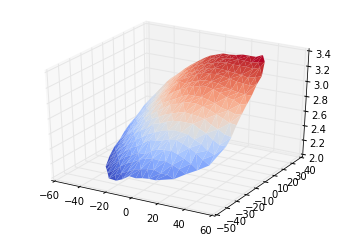

In [8]:
fig = plt.figure()
ax = fig.gca(projection='3d')
surf = ax.plot_trisurf(x, y, z, cmap=cm.coolwarm, linewidth=0)

Solve (OK, we're lazy - optimize) the plane equation.

In [9]:
def f(k_x, k_y, b):
    return z + k_x * x + k_y * y + b

In [10]:
def fopt(k):
    k_x, k_y, b = k
    return f(k_x, k_y, b)

In [11]:
res = leastsq(fopt, [0, 0, 0])

In [12]:
res

(array([-0.00570786, -0.01282366, -2.78900522]), 3)

In [13]:
k_x, k_y, b = res[0]

Once we have flattened the print bed, this is the residual curve:

In [14]:
z2 = f(k_x, k_y, b)

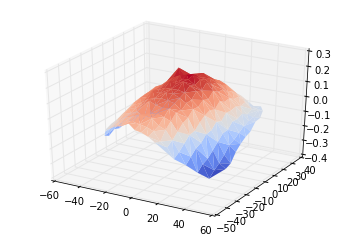

In [15]:
fig = plt.figure()
ax = fig.gca(projection='3d')
surf = ax.plot_trisurf(x, y, z2, cmap=cm.coolwarm, linewidth=0)

Cool, eh? Verify that the center point (highest or lowest point of the dome or the cup) is really close to 0, 0 - if not, adjust the offset values.

In my example, the curve has a distinct saddle-like shape. This is most likely due to some skew in printer frame geometry - I'm still finishing the printer construction and haven't had time to fix everything. I'll ignore that for the moment.

## Geometry calibration

Next, let's flatten the residual curve. We'll assume that the diagonal rod length is known and accurate (add the carbon rod length to the steel ball diameter, in case of the magnetic arms). Hence, we'll only have to solve the delta radius error.

The delta printer kinematics is described here:
http://reprap.org/wiki/File:Rostock_Delta_Kinematics_3.pdf

In [16]:
# Known variables
# DELTA_DIAGONAL_ROD
L = 210.0
# DELTA_RADIUS
DR = 105.3

Inverse kinematics equations:

In [17]:
def inv_kin(L, DR, x, y):
    Avx = 0
    Avy = DR

    Bvx = DR * np.cos(30.0 / (2*np.pi))
    Bvy = -DR * np.sin(30.0 / (2*np.pi))

    Cvx = -DR * np.cos(30.0 / (2*np.pi))
    Cvy = -DR * np.sin(30.0 / (2*np.pi))

    Acz = np.sqrt(L**2 - (x - Avx)**2 - (y - Avy)**2)
    Bcz = np.sqrt(L**2 - (x - Bvx)**2 - (y - Bvy)**2)
    Ccz = np.sqrt(L**2 - (x - Cvx)**2 - (y - Cvy)**2)
    
    return Acz, Bcz, Ccz

In [18]:
Acz, Bcz, Ccz = inv_kin(L, DR, x, y)

For true L and DR, these return the zero height locations.
For our imperfect dimensions, we need to calculate the actual x,y,z coordinates with forward kinematics. Since we're lazy, we solve the forward kinematic equations numerically from the inverse ones.

In [19]:
def fwd_kin_scalar(L, DR, Az, Bz, Cz):
    
    # now, solve the inv_kin equation:
    # Acz, Bcz, Ccz = inv_kin(L, DR, x, y, z)
    # for x, y, z
    
    def fopt(x_):
        x, y, z = x_
        Aczg, Bczg, Cczg = inv_kin(L, DR, x, y)
        #print("F: ", Aczg, Bczg, Cczg)
        return [Aczg+z-Az, Bczg+z-Bz, Cczg+z-Cz]
    res = leastsq(fopt, [0, 0, 1])
    x, y, z = res[0]
    
    return x, y, z
fwd_kin = np.vectorize(fwd_kin_scalar)

Test fwd_kin correctness

In [20]:
def test_fwd_kin_reciprocity():
    xs = np.linspace(-100, 70, 51)
    ys = np.linspace(60, -50, 51)
    zs = np.linspace(0, 50, 51)
    for i, (x, y, z) in enumerate(zip(xs, ys, zs)):
        Acz, Bcz, Ccz = inv_kin(L, DR, x, y)
        xi, yi, zi = fwd_kin(L, DR, Acz+z, Bcz+z, Ccz+z)
        assert np.abs(x-xi) < 1e-5
        assert np.abs(y-yi) < 1e-5
        assert np.abs(z-zi) < 1e-5
test_fwd_kin_reciprocity()

Now for the beef. Define the error incurred by incorrect delta radius value.

In [21]:
def Z_err(e):
    # idealized inverse kinematics (this is what the firmware calculates)
    Acz, Bcz, Ccz = inv_kin(L, DR, x, y)
    # and this is where the extruder ends up in real world
    x_e, y_e, z_e = fwd_kin(L, DR+e, Acz, Bcz, Ccz)
    
    return z_e

Define the optimization function.

In [22]:
def fopt(x):
    e, = x
    zerr = Z_err(e)
    # ignore any constant offset
    zerr = zerr - np.mean(zerr)
    return np.sum((z2-zerr)**2)

Run the optimization. This might take a few moments.

In [23]:
res2 = minimize(fopt, 
                np.array([-2]), 
                method='COBYLA', 
                options={"disp": True})
res2

  status: 1
       x: array([ 2.22597422])
     fun: 1.4616350668425031
   maxcv: 0.0
    nfev: 26
 success: True
 message: 'Optimization terminated successfully.'

In [24]:
e, = res2.x

e

2.2259742187499998

In [25]:
zerr = Z_err(e)
zerr = zerr - np.mean(zerr)

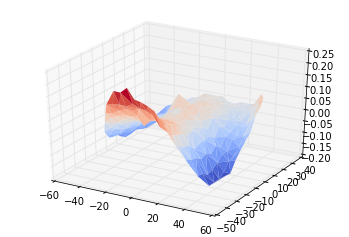

In [26]:
fig = plt.figure()
ax = fig.gca(projection='3d')
surf = ax.plot_trisurf(x, y, z2-zerr, cmap=cm.coolwarm, linewidth=0)

Note the z axis values. The residual has flattened quite a bit. Take the e value and add that to DELTA_RADIUS and upload the new firmware. You still need to re-run calibration and most likely also readjust Z_PROBE_OFFSET_FROM_EXTRUDER to ensure you get a perfect first layer height.
